In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import MDS
from PIL import Image
import os
import pingouin as pg
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import orthogonal_procrustes
from nltk.corpus import wordnet as wn
import json
import pickle
import gc

import ecoset
import categorization as cat
import train
import utils

# Seed for reproducibility
np.random.seed(2023)
tf.random.set_seed(2023)


def clear_model():
    # Check if model variable exists
    if "model" in globals():
        del globals()["model"]
        tf.keras.backend.clear_session()
        gc.collect()

2023-09-02 20:21:13.637075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-02 20:21:17.693225: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-02 20:21:17.693322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-02 20:21:17.693329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Dataset

800 images from imagenet + CUB200.

- Superordinate: 400 vehicles and 400 animals
- Basic: 200 cars, 200 busses, 200 dogs, 200 birds
- Subordinate: 40 per species of birds

Half of these images are from the training set (therefore we'll use it as category knowledge). The other half are from the Train/validation set, so we'll use them in the categorization test.

Images preprocessed by centering the features and resizing to 224x224.


In [2]:
# Load csv
imgInfo = pd.read_csv("./deepCatsTrainImages.csv")

# Rename cat columns
imgInfo = imgInfo.rename(
    columns={
        "cat1": "super",
        "cat2": "basic",
        "cat3": "sub",
    }
)

# Add a column delineating train/test set
imgInfo["set"] = "train"

In [3]:
# Load csv
tmp = pd.read_csv("./deepCatsTestImages.csv")

# Rename cat columns
tmp = tmp.rename(
    columns={
        "cat1": "super",
        "cat2": "basic",
        "cat3": "sub",
    }
)

# Add a column delineating train/test set
tmp["set"] = "test"

# Concatenate
imgInfo = pd.concat([imgInfo, tmp], axis=0)

# Reset index
imgInfo = imgInfo.reset_index(drop=True)

imgInfo.head()

,path,name,super,basic,sub,set
0,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0030_130191.jpg,animal,bird,CUB_136.Barn_Swallow,train
1,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0065_131555.jpg,animal,bird,CUB_136.Barn_Swallow,train
2,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0060_130110.jpg,animal,bird,CUB_136.Barn_Swallow,train
3,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0042_132043.jpg,animal,bird,CUB_136.Barn_Swallow,train
4,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0016_130678.jpg,animal,bird,CUB_136.Barn_Swallow,train


In [4]:
imgFile = "./images/deepCatImgs.npy"

if not os.path.exists(imgFile):
    # Preallocate array for images
    allImgs = np.zeros((len(imgInfo), 224, 224, 3), dtype=np.float32)

    # Loop through images
    for i, row in imgInfo.iterrows():
        # Load image
        img = Image.open(row["path"])

        # Preprocess image
        img = ecoset.preprocess_alexnet(img)

        # Add image to array
        allImgs[i] = img

    # Save images as a npy
    np.save(imgFile, allImgs)
else:
    # Load images from npy
    print("Loading images from file...")
    allImgs = np.load(imgFile)

print(allImgs.shape)

Loading images from file...
(800, 224, 224, 3)


# Models and representations

Generate representations from AlexNet trained in Mehrer et al 2022.

- 10 models are trained on Ecoset (basic-level categories)
- 10 models are trained on ImageNet (mixed levels of abstraction)


In [5]:
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ecosetRepFile = "./representations/ecosetReps.npy"

if not os.path.exists(ecosetRepFile):
    # Get ecoset representations
    ecosetReps = np.zeros((len(seeds), len(allImgs), 5, 5, 4096), dtype=np.float32)

    for i, seed in enumerate(seeds):
        # Cleanup so we don't run out of GPU memory
        clear_model()

        # Load model
        weightPath = f"./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(allImgs)

        # Add rep to big representation array
        ecosetReps[i] = reps
else:
    # Load representations
    ecosetReps = np.load(ecosetRepFile)

ecosetReps.shape

2023-09-02 20:21:27.546532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-02 20:21:27.655453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-02 20:21:27.656664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-02 20:21:27.685066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89 loaded successfully.


2023-09-02 20:21:33.251386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8202
2023-09-02 20:21:34.996437: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-02 20:21:37.834011: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


25/25 [==============================] - 8s 48ms/step
Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_02/model.ckpt_epoch89 loaded successfully.
25/25 [==============================] - 1s 50ms/step
Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_03/model.ckpt_epoch89 loaded successfully.
25/25 [==============================] - 1s 50ms/step
Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_04/model.ckpt_epoch89 loaded successfully.
25/25 [==============================] - 1s 50ms/step
Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_05/model.ckpt_epoch89 loaded successfully.
25/25 [==============================] - 1s 50ms/step
Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_06/model.ckpt_epoch89 loaded successfully.
25/25 [==============================] - 1s 49ms/step
Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_07/model.ck

(10, 800, 5, 5, 4096)

In [6]:
ecosetSimMatFile = "./representations/ecosetSimMat.npy"

if not os.path.exists(ecosetSimMatFile):
    # Preallocate array for similarity matrices
    ecosetSimMat = np.zeros((len(seeds), len(allImgs), len(allImgs)), dtype=np.float32)

    # Loop through models
    for i, modelReps in enumerate(ecosetReps):
        # Flatten model reps
        modelReps = modelReps.reshape(modelReps.shape[0], -1)

        # Calculate similarity matrix using default GCM
        ecosetSimMat[i] = cat.default_gcm_sim_mat(modelReps)

    # Save similarity matrices
    np.save(ecosetSimMatFile, ecosetSimMat)
else:
    # Load similarity matrices
    ecosetSimMat = np.load(ecosetSimMatFile)

del ecosetReps
ecosetSimMat.shape

(10, 800, 800)

In [7]:
imagenetRepFiles = "./representations/imagenetReps.npy"

if not os.path.exists(imagenetRepFiles):
    # Get ecoset representations
    imagenetReps = np.zeros((len(seeds), len(allImgs), 5, 5, 4096), dtype=np.float32)

    for i, seed in enumerate(seeds):
        # Cleanup so we don't run out of GPU memory
        clear_model()

        # Load model
        weightPath = f"./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath, output_shape=1000)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(allImgs)

        # Add rep to big representation array
        imagenetReps[i] = reps
else:
    # Load representations
    imagenetReps = np.load(ecosetRepFile)

imagenetReps.shape

Weights from ./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89 loaded successfully.
25/25 [==============================] - 1s 51ms/step
Weights from ./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_02/model.ckpt_epoch89 loaded successfully.
25/25 [==============================] - 1s 51ms/step
Weights from ./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_03/model.ckpt_epoch89 loaded successfully.
25/25 [==============================] - 1s 50ms/step
Weights from ./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_04/model.ckpt_epoch89 loaded successfully.
25/25 [==============================] - 1s 50ms/step
Weights from ./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_05/model.ckpt_epoch89 loaded successfully.
25/25 [==============================] - 1s 50ms/step
Weights from ./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_06/model.ckpt_epoch89 loaded successfully.
25/25 [===============

(10, 800, 5, 5, 4096)

In [8]:
imagenetSimMatFile = "./representations/imagenetSimMat.npy"

if not os.path.exists(imagenetSimMatFile):
    # Preallocate array for similarity matrices
    imagenetSimMat = np.zeros(
        (len(seeds), len(allImgs), len(allImgs)), dtype=np.float32
    )

    # Loop through models
    for i, modelReps in enumerate(imagenetReps):
        # Flatten model reps
        modelReps = modelReps.reshape(modelReps.shape[0], -1)

        # Calculate similarity matrix using default GCM
        imagenetSimMat[i] = cat.default_gcm_sim_mat(modelReps)

    # Save similarity matrices
    np.save(imagenetSimMatFile, imagenetSimMat)
else:
    # Load similarity matrices
    imagenetSimMat = np.load(imagenetSimMatFile)

del imagenetReps
imagenetSimMat.shape

(10, 800, 800)

# Categorization

We use a LBA to simulate a category verification task where each model is a
different participant. We perform the task in each level of abstraction. For
each image, we calculate a drift rate to verify that that image belongs to its
category by calculating similarity of that image's representation with the
similarity of every other image of the same category (GCM-like).


In [9]:
criterion = [11, 9]
maxImgs = 20

performanceFile = f"./cat_performance.csv"
performanceFile += ".csv"
if not os.path.exists(performanceFile):
    performance = pd.DataFrame(
        columns=[
            "model",
            "image",
            "category",
            "level",
            "response",
            "RT",
            "crit",
            "maxImgs",
            "seed",
        ]
    )

    # Loop through models
    for seed in seeds:
        tmp = cat.cat_verification_from_mat(
            simMat=ecosetSimMat[seed - 1],
            imgInfo=imgInfo,
            modelName="ecoset",
            criterion=criterion[0],
            maxImgs=maxImgs,
        )
        # Add seed
        tmp["seed"] = seed

        # Add to performance
        performance = pd.concat([performance, tmp], axis=0)

        tmp = cat.cat_verification_from_mat(
            simMat=imagenetSimMat[seed - 1],
            imgInfo=imgInfo,
            modelName="imagenet",
            criterion=criterion[1],
            maxImgs=maxImgs,
        )
        # Add seed
        tmp["seed"] = seed

        # Add to performance
        performance = pd.concat([performance, tmp], axis=0)

    performance.to_csv(performanceFile, index=False)
else:
    print("Loading performance from file")
    performance = pd.read_csv(performanceFile)

print(
    performance.groupby(["model", "level"])["response"].agg(
        lambda x: np.mean(x == "yes")
    )
)
print(performance.groupby(["model", "level"])["RT"].agg(["mean", "std"]))

Loading performance from file
model     level
ecoset    basic    0.87650
          sub      0.98100
          super    0.76250
imagenet  basic    0.85450
          sub      0.96400
          super    0.74125
Name: response, dtype: float64
                    mean       std
model    level                    
ecoset   basic  0.971650  0.017853
         sub    0.969147  0.013624
         super  0.979869  0.014006
imagenet basic  0.945453  0.034212
         sub    0.957170  0.019041
         super  0.952929  0.029296


# ANOVA Analysis

We treat each model as a different participant so we do a mixed effects ANOVA where we have a between subject factor of training set (Ecoset or Imagenet) and a within-subject factor of level of categorization (Superordinate, basic, subordiante).


In [10]:
# Add a subject column that is a combo of model and seed
performance["subject"] = performance["model"] + performance["seed"].astype(str)

# Group data by model and level
sbjData = (
    performance.groupby(["subject", "model", "level"])
    .agg({"response": [lambda x: np.mean(x == "yes")], "RT": ["mean"]})
    .reset_index()
)
sbjData.columns = sbjData.columns.droplevel(1)
sbjData = sbjData.rename(columns={"response": "accuracy", "RT": "RT"})
sbjData.head()

,subject,model,level,accuracy,RT
0,ecoset1,ecoset,basic,0.8725,0.971342
1,ecoset1,ecoset,sub,0.9800,0.968770
2,ecoset1,ecoset,super,0.7825,0.979530
3,ecoset10,ecoset,basic,0.8875,0.971103
4,ecoset10,ecoset,sub,0.9900,0.968078


In [11]:
pg.mixed_anova(
    sbjData, dv="accuracy", within="level", between="model", subject="subject"
)

/data/venv/research2/lib/python3.8/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,model,0.006050,1,18,0.006050,10.427677,4.653850e-03,0.366814,NaN
1,level,0.486900,2,36,0.243450,910.369574,1.499439e-31,0.980611,0.656009
2,Interaction,0.000073,2,36,0.000036,0.135945,8.733370e-01,0.007496,NaN


In [12]:
pg.mixed_anova(sbjData, dv="RT", within="level", between="model", subject="subject")

/data/venv/research2/lib/python3.8/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,model,0.007066,1,18,0.007066,2600.633580,6.373861e-21,0.993126,NaN
1,level,0.000622,2,36,0.000311,251.999682,6.766538e-22,0.933333,0.503761
2,Interaction,0.000711,2,36,0.000356,288.044443,7.092251e-23,0.941185,NaN


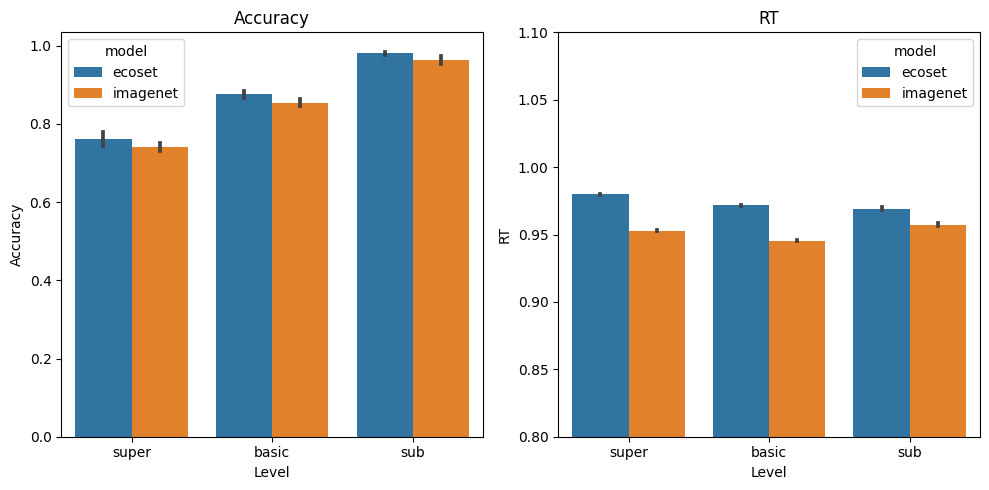

In [13]:
# Plot accuracy and RT
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

# Accuracy
sns.barplot(
    data=sbjData,
    x="level",
    y="accuracy",
    hue="model",
    ax=ax[0],
    order=["super", "basic", "sub"],
)
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Level")
ax[0].set_ylabel("Accuracy")

# RT
sns.barplot(
    data=sbjData,
    x="level",
    y="RT",
    hue="model",
    ax=ax[1],
    order=["super", "basic", "sub"],
)
# Set y range
ax[1].set_ylim(0.8, 1.1)
ax[1].set_title("RT")
ax[1].set_xlabel("Level")
ax[1].set_ylabel("RT")

plt.tight_layout()
plt.show()

# MDS Analysis

We now look at how the categories are represented in the representational space.


In [14]:
ecosetMDSFile = "./representations/ecosetMDS.npy"
imagenetMDSFile = "./representations/imagenetMDS.npy"

if not (os.path.exists(ecosetMDSFile) and os.path.exists(imagenetMDSFile)):
    # Turn similarity matrices to distance matrices
    ecosetDistMat = 1 - ecosetSimMat
    imagenetDistMat = 1 - imagenetSimMat

    # Average across models
    ecosetDistMat = np.mean(ecosetDistMat, axis=0)
    imagenetDistMat = np.mean(imagenetDistMat, axis=0)

    eps = 1e-3
    metric = True

    # Create MDS for Ecoset
    ecosetMDS = MDS(
        n_components=2,
        dissimilarity="precomputed",
        normalized_stress="auto",
        metric=metric,
        eps=eps,
        n_init=10,
    )
    ecosetSolution = ecosetMDS.fit_transform(ecosetDistMat)
    print(ecosetMDS.stress_)

    # Create MDS for Imagenet
    imagenetMDS = MDS(
        n_components=2,
        dissimilarity="precomputed",
        normalized_stress="auto",
        metric=metric,
        eps=eps,
        n_init=10,
    )
    imagenetSolution = imagenetMDS.fit_transform(imagenetDistMat)
    print(imagenetMDS.stress_)

    # Save
    np.save(ecosetMDSFile, ecosetSolution)
    np.save(imagenetMDSFile, imagenetSolution)
else:
    ecosetSolution = np.load(ecosetMDSFile)
    imagenetSolution = np.load(imagenetMDSFile)

print(ecosetSolution.shape)
print(imagenetSolution.shape)

9171.519574895978
12821.682804052944
(800, 2)
(800, 2)


In [15]:
# Color mapping
colorMap = {
    "bird": sns.color_palette(n_colors=4)[0],
    "dog": sns.color_palette(n_colors=4)[1],
    "car": sns.color_palette(n_colors=4)[2],
    "bus": sns.color_palette(n_colors=4)[3],
}
colors = list(imgInfo["basic"].map(colorMap))
# Market mapping
markerMap = {
    float("nan"): "o",
    "CUB_002.Laysan_Albatross": "s",
    "CUB_048.European_Goldfinch": "s",
    "CUB_094.White_breasted_Nuthatch": "p",
    "CUB_136.Barn_Swallow": "P",
    "CUB_199.Winter_Wren": "*",
}
markers = list(imgInfo["sub"].map(markerMap))

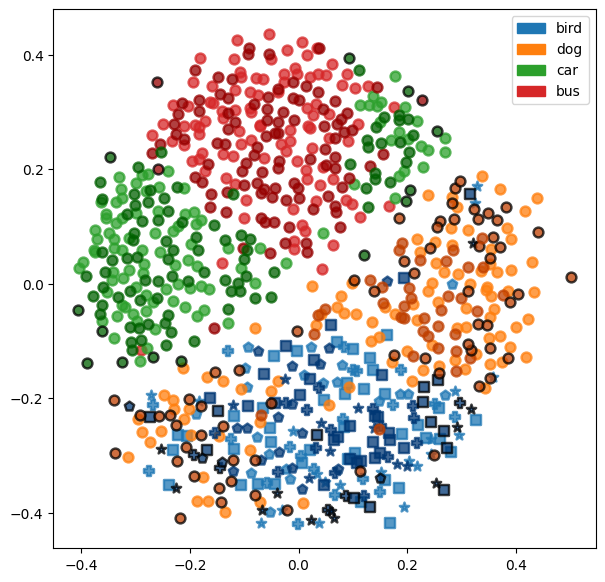

In [16]:
# Plot MDS
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Plot MDS
for i, row in imgInfo.iterrows():
    edgecolors = None
    color = colors[i]
    if row["set"] == "test":
        color = [c - 0.25 if c - 0.25 > 0 else 0 for c in color]
        logIdx = (
            (performance["model"] == "ecoset")
            & (performance["image"] == row["name"])
            & (performance["level"] == "basic")
        )
        noResponses = performance.loc[logIdx]["response"].values == "no"
        if np.any(noResponses):
            edgecolors = "k"

    ax.scatter(
        ecosetSolution[i, 0],
        ecosetSolution[i, 1],
        s=50,
        color=color,
        marker=markers[i],
        edgecolors=edgecolors,
        alpha=0.75,
        linewidths=1.75,
    )

legendHandles = [
    mpatches.Patch(color=colorMap["bird"], label="bird"),
    mpatches.Patch(color=colorMap["dog"], label="dog"),
    mpatches.Patch(color=colorMap["car"], label="car"),
    mpatches.Patch(color=colorMap["bus"], label="bus"),
]
ax.legend(handles=legendHandles, loc="upper right")

fig.show()

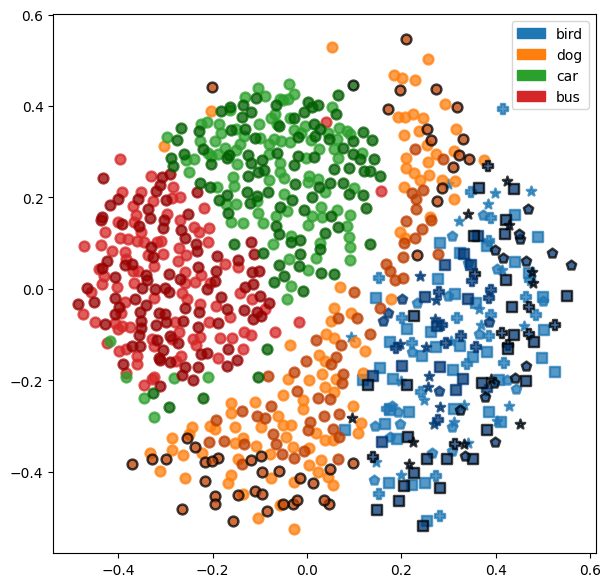

In [17]:
# Plot MDS
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Plot MDS
for i, row in imgInfo.iterrows():
    edgecolors = None
    color = colors[i]
    if row["set"] == "test":
        color = [c - 0.25 if c - 0.25 > 0 else 0 for c in color]
        logIdx = (
            (performance["model"] == "imagenet")
            & (performance["image"] == row["name"])
            & (performance["level"] == "basic")
        )
        noResponses = performance.loc[logIdx]["response"].values == "no"
        if np.any(noResponses):
            edgecolors = "k"

    ax.scatter(
        imagenetSolution[i, 0],
        imagenetSolution[i, 1],
        s=50,
        color=color,
        marker=markers[i],
        edgecolors=edgecolors,
        alpha=0.75,
        linewidths=1.75,
    )

legendHandles = [
    mpatches.Patch(color=colorMap["bird"], label="bird"),
    mpatches.Patch(color=colorMap["dog"], label="dog"),
    mpatches.Patch(color=colorMap["car"], label="car"),
    mpatches.Patch(color=colorMap["bus"], label="bus"),
]
ax.legend(handles=legendHandles, loc="upper right")

fig.show()

# Cluster Indices

Now we calculate cluster indices.

$ cluster index = MeanWithinCategorySimilarity - MeanBetweenCategorySimilarity $

Because we are using GCM for similarity (bounded 0 to 1):

+1 means the category is perfectly clustered with the non-category exemplars really far away.

-1 means the category is really far away from each other with non-category exemplars perfectly clustered.

0 means that the category and non-category exemplars are equally well clustered (so it's probably random)


In [18]:
levelMap = {
    "super": ["animal", "vehicle"],
    "basic": ["bird", "dog", "car", "bus"],
    "sub": [
        "CUB_002.Laysan_Albatross",
        "CUB_048.European_Goldfinch",
        "CUB_094.White_breasted_Nuthatch",
        "CUB_136.Barn_Swallow",
        "CUB_199.Winter_Wren",
    ],
}

ecosetSimCluster = {}
for imgSet in ["train", "test"]:
    simMat = np.mean(ecosetSimMat, axis=0)
    for level in ["super", "basic", "sub"]:
        for category in levelMap[level]:
            cluster = cat.cluster_index(imgInfo, level, category, imgSet, simMat)
            # print(f"{imgSet} {model} {level} {category} cluster: {cluster}")
            ecosetSimCluster[imgSet + "-" + category] = cluster

ecosetSimCluster

{'train-animal': 0.038464834241280776,
 'train-vehicle': 0.06735942327244271,
 'train-bird': 0.04418947042786714,
 'train-dog': 0.03481497191982441,
 'train-car': 0.06413582524371264,
 'train-bus': 0.08426900827999062,
 'train-CUB_002.Laysan_Albatross': 0.04710845034373434,
 'train-CUB_048.European_Goldfinch': 0.059836516145028495,
 'train-CUB_094.White_breasted_Nuthatch': 0.05567223644570307,
 'train-CUB_136.Barn_Swallow': 0.04775957352236704,
 'train-CUB_199.Winter_Wren': 0.060423327205996746,
 'test-animal': 0.034651018448147775,
 'test-vehicle': 0.06429892310808272,
 'test-bird': 0.045953976507379535,
 'test-dog': 0.03016946980498647,
 'test-car': 0.05130232023301751,
 'test-bus': 0.07923883135532495,
 'test-CUB_002.Laysan_Albatross': 0.039132626189997244,
 'test-CUB_048.European_Goldfinch': 0.060032573224682584,
 'test-CUB_094.White_breasted_Nuthatch': 0.05752693041374812,
 'test-CUB_136.Barn_Swallow': 0.057510597403896524,
 'test-CUB_199.Winter_Wren': 0.061316550958313454}

In [19]:
ecosetSuperTrainCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["super"] and key.split("-")[0] == "train"
]
ecosetSuperTrainCluster = np.mean(ecosetSuperTrainCluster)
ecosetSuperTestCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["super"] and key.split("-")[0] == "test"
]
ecosetSuperTestCluster = np.mean(ecosetSuperTestCluster)

ecosetBasicTrainCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["basic"] and key.split("-")[0] == "train"
]
ecosetBasicTrainCluster = np.mean(ecosetBasicTrainCluster)
ecosetBasicTestCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["basic"] and key.split("-")[0] == "test"
]
ecosetBasicTestCluster = np.mean(ecosetBasicTestCluster)

ecosetSubTrainCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["sub"] and key.split("-")[0] == "train"
]
ecosetSubTrainCluster = np.mean(ecosetSubTrainCluster)
ecosetSubTestCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["sub"] and key.split("-")[0] == "test"
]
ecosetSubTestCluster = np.mean(ecosetSubTestCluster)

print(f"Ecoset Cluster Indices:")
print(f"Super train cluster index: {ecosetSuperTrainCluster}")
print(f"Basic train cluster index: {ecosetBasicTrainCluster}")
print(f"Sub train cluster index: {ecosetSubTrainCluster}")
print("")
print(f"Super test cluster index: {ecosetSuperTestCluster}")
print(f"Basic test cluster index: {ecosetBasicTestCluster}")
print(f"Sub test cluster index: {ecosetSubTestCluster}")

Ecoset Cluster Indices:
Super train cluster index: 0.05291212875686174
Basic train cluster index: 0.0568523189678487
Sub train cluster index: 0.05416002073256594

Super test cluster index: 0.049474970778115246
Basic test cluster index: 0.051666149475177114
Sub test cluster index: 0.055103855638127586


In [20]:
imagenetSimCluster = {}
for imgSet in ["train", "test"]:
    simMat = np.mean(imagenetSimMat, axis=0)
    for level in ["super", "basic", "sub"]:
        for category in levelMap[level]:
            cluster = cat.cluster_index(imgInfo, level, category, imgSet, simMat)
            # print(f"{imgSet} {model} {level} {category} cluster: {cluster}")
            imagenetSimCluster[imgSet + "-" + category] = cluster

imagenetSimCluster

{'train-animal': 0.006620660669255485,
 'train-vehicle': 0.08523118696711468,
 'train-bird': 0.02980499515160162,
 'train-dog': 0.021160962317146426,
 'train-car': 0.08309194573558343,
 'train-bus': 0.09035645353357596,
 'train-CUB_002.Laysan_Albatross': 0.05218086454036985,
 'train-CUB_048.European_Goldfinch': 0.07102523989975451,
 'train-CUB_094.White_breasted_Nuthatch': 0.05730374788767417,
 'train-CUB_136.Barn_Swallow': 0.04748922938971145,
 'train-CUB_199.Winter_Wren': 0.06326856786875346,
 'test-animal': 0.003102476373580687,
 'test-vehicle': 0.0846530419062842,
 'test-bird': 0.03398555087007654,
 'test-dog': 0.017736936101136802,
 'test-car': 0.0724109760563783,
 'test-bus': 0.0895845106840435,
 'test-CUB_002.Laysan_Albatross': 0.048330056863395754,
 'test-CUB_048.European_Goldfinch': 0.0656305634151948,
 'test-CUB_094.White_breasted_Nuthatch': 0.06862134286447574,
 'test-CUB_136.Barn_Swallow': 0.05816564227797483,
 'test-CUB_199.Winter_Wren': 0.06780024897111092}

In [21]:
imagenetSuperTrainCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["super"] and key.split("-")[0] == "train"
]
imagenetSuperTrainCluster = np.mean(imagenetSuperTrainCluster)
imagenetSuperTestCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["super"] and key.split("-")[0] == "test"
]
imagenetSuperTestCluster = np.mean(imagenetSuperTestCluster)

imagenetBasicTrainCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["basic"] and key.split("-")[0] == "train"
]
imagenetBasicTrainCluster = np.mean(imagenetBasicTrainCluster)
imagenetBasicTestCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["basic"] and key.split("-")[0] == "test"
]
imagenetBasicTestCluster = np.mean(imagenetBasicTestCluster)

imagenetSubTrainCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["sub"] and key.split("-")[0] == "train"
]
imagenetSubTrainCluster = np.mean(imagenetSubTrainCluster)
imagenetSubTestCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["sub"] and key.split("-")[0] == "test"
]
imagenetSubTestCluster = np.mean(imagenetSubTestCluster)

print(f"imagenet Cluster Indices:")
print(f"Super train cluster index: {imagenetSuperTrainCluster}")
print(f"Basic train cluster index: {imagenetBasicTrainCluster}")
print(f"Sub train cluster index: {imagenetSubTrainCluster}")
print("")
print(f"Super test cluster index: {imagenetSuperTestCluster}")
print(f"Basic test cluster index: {imagenetBasicTestCluster}")
print(f"Sub test cluster index: {imagenetSubTestCluster}")

imagenet Cluster Indices:
Super train cluster index: 0.04592592381818508
Basic train cluster index: 0.05610358918447686
Sub train cluster index: 0.05825352991725269

Super test cluster index: 0.04387775913993244
Basic test cluster index: 0.053429493427908786
Sub test cluster index: 0.06170957087843041


# Calculate similarity matrix across training


In [22]:
modelsDir = "./models/deepCats/AlexNet/twoHotFreezeBasic"
nModels = len(os.listdir(modelsDir))

# if file exists
fileName = "./representations/deepcatSimMat.npy"
if not os.path.exists(fileName):
    # Preallocate array for each model
    epochSimMat = np.zeros((nModels, 10, allImgs.shape[0], allImgs.shape[0]))

    for i, modelDir in enumerate(os.listdir(modelsDir)):
        print(f"Computing epoch similarity matrix for {modelDir}...")
        epochSimMat[i] = utils.compute_sims_over_training(
            os.path.join(modelsDir, modelDir),
            "fc7",
            allImgs,
            {"TwoHotBirdAccuracy": train.TwoHotBirdAccuracy},
        )

    # Save
    np.save(fileName, epochSimMat)
else:
    epochSimMat = np.load(fileName)

Computing epoch similarity matrix for seed04...
Processing file: ./models/deepCats/AlexNet/twoHotFreezeBasic/seed04/epoch01-val_loss2.87.hdf5
25/25 [==============================] - 1s 51ms/step
Processing file: ./models/deepCats/AlexNet/twoHotFreezeBasic/seed04/epoch02-val_loss2.67.hdf5
25/25 [==============================] - 1s 50ms/step
Processing file: ./models/deepCats/AlexNet/twoHotFreezeBasic/seed04/epoch03-val_loss2.60.hdf5
25/25 [==============================] - 1s 50ms/step
Processing file: ./models/deepCats/AlexNet/twoHotFreezeBasic/seed04/epoch04-val_loss2.56.hdf5
25/25 [==============================] - 1s 51ms/step
Processing file: ./models/deepCats/AlexNet/twoHotFreezeBasic/seed04/epoch05-val_loss2.55.hdf5
25/25 [==============================] - 1s 50ms/step
Processing file: ./models/deepCats/AlexNet/twoHotFreezeBasic/seed04/epoch06-val_loss2.53.hdf5
25/25 [==============================] - 1s 51ms/step
Processing file: ./models/deepCats/AlexNet/twoHotFreezeBasic/see

In [23]:
# Check if MDS solution already exists
fileName = "./representations/deepCatsMDS.npy"
if not os.path.exists(fileName):
    # Turn similarity matrices to distance matrices
    epochDistMat = 1 - epochSimMat

    # Average across models
    epochDistMat = np.mean(epochDistMat, axis=0)

    # Preallocate mds array
    epochMDS = np.zeros(
        (epochDistMat.shape[0], epochDistMat.shape[1], 2), dtype=np.float32
    )

    # At each epoch, calulate an MDS solution
    for i, epochDist in enumerate(epochDistMat):
        # Create MDS for Ecoset
        tmp = MDS(
            n_components=2,
            dissimilarity="precomputed",
            normalized_stress="auto",
            metric=metric,
            eps=eps,
            n_init=10,
        )
        epochSolution = tmp.fit_transform(epochDist)
        print(tmp.stress_)

        epochMDS[i] = epochSolution
else:
    epochMDS = np.load(fileName)

26014.29540507389
28400.94657010824
29736.004191982138
30359.956629106353
30813.042451410518
31029.61351544978
31076.883006480788
31100.861496195528
31195.755828254434
31234.900666344176


In [24]:
# Preallocate transformed MDS array
epochMDSProc = np.zeros_like(epochMDS)

# The first epoch is transformed to match pretrained epoch
transform, scale = orthogonal_procrustes(epochMDS[0], ecosetSolution)
epochMDSProc[0] = np.dot(epochMDS[0], transform)

# Loop through each MDS solution and use Procrustes to the previous step
for i in range(1, epochMDS.shape[0]):
    # Get the previous step
    prevStep = epochMDSProc[i - 1]
    # Get the current step
    currStep = epochMDS[i]

    transform, scale = orthogonal_procrustes(currStep, prevStep)

    epochMDSProc[i] = np.dot(currStep, transform)

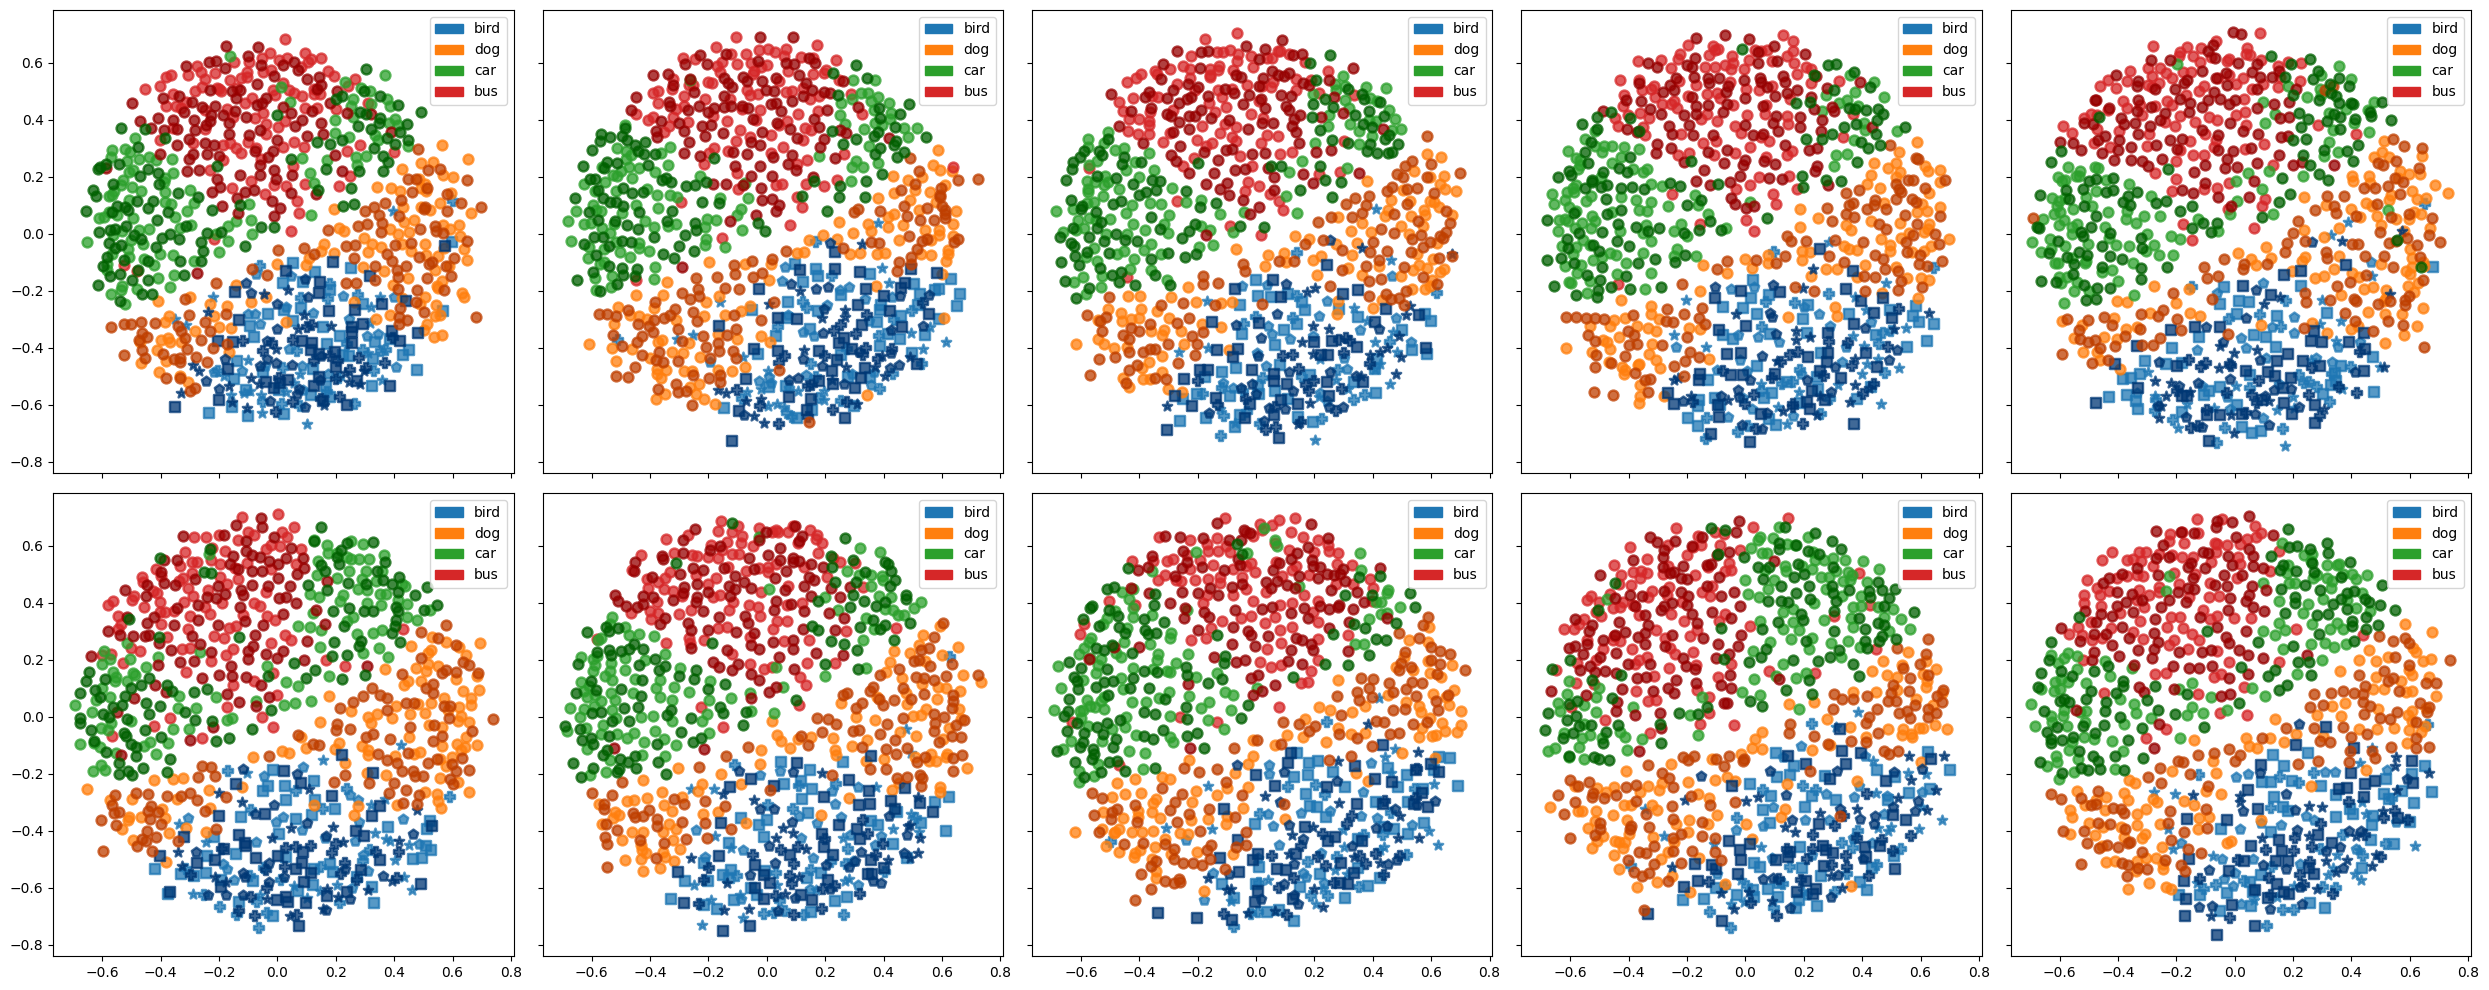

In [25]:
# Create subplot of each MDS solution
fig, ax = plt.subplots(2, 5, figsize=(25, 10), sharex=True, sharey=True)

# Plot MDS
for index in range(epochMDS.shape[0]):
    for i, row in imgInfo.iterrows():
        edgecolors = None
        color = colors[i]
        if row["set"] == "test":
            color = [c - 0.25 if c - 0.25 > 0 else 0 for c in color]
            logIdx = (
                (performance["model"] == "ecoset")
                & (performance["image"] == row["name"])
                & (performance["level"] == "basic")
            )

        ax[index // 5, index % 5].scatter(
            epochMDSProc[index, i, 0],
            epochMDSProc[index, i, 1],
            s=50,
            color=color,
            marker=markers[i],
            edgecolors=edgecolors,
            alpha=0.75,
            linewidths=1.75,
        )

    legendHandles = [
        mpatches.Patch(color=colorMap["bird"], label="bird"),
        mpatches.Patch(color=colorMap["dog"], label="dog"),
        mpatches.Patch(color=colorMap["car"], label="car"),
        mpatches.Patch(color=colorMap["bus"], label="bus"),
    ]
    ax[index // 5, index % 5].legend(handles=legendHandles, loc="upper right")

# Tight layout
plt.tight_layout()

In [26]:
# Create dataframe
epochPerf = pd.DataFrame(
    columns=[
        "model",
        "image",
        "category",
        "level",
        "response",
        "RT",
        "crit",
        "maxImgs",
        "epoch",
    ]
)

criterion = 6
# Loop through models and epochs
for i, modelSims in enumerate(epochSimMat):
    for j, epochSims in enumerate(modelSims):
        tmp = cat.cat_verification_from_mat(
            simMat=epochSims,
            imgInfo=imgInfo,
            modelName=f"seed{i:02}",
            criterion=criterion,
            maxImgs=20,
        )

        # Add epoch
        tmp["epoch"] = j

        # Add to dataframe
        epochPerf = pd.concat([epochPerf, tmp])

# Summarize accuracy over epochs
epochPerf.groupby(["level", "epoch"])["response"].agg(lambda x: np.mean(x == "yes"))

level  epoch
basic  0        0.54300
       1        0.16175
       2        0.04400
       3        0.01675
       4        0.01225
       5        0.00875
       6        0.00700
       7        0.00700
       8        0.00575
       9        0.00575
sub    0        0.88300
       1        0.44300
       2        0.16200
       3        0.06600
       4        0.04500
       5        0.03100
       6        0.02600
       7        0.02400
       8        0.02400
       9        0.02400
super  0        0.29750
       1        0.02775
       2        0.00275
       3        0.00125
       4        0.00000
       5        0.00050
       6        0.00025
       7        0.00000
       8        0.00000
       9        0.00000
Name: response, dtype: float64